In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd
import datetime as dt
from flask import jsonify

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
#Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
MeasurementClass = Base.classes.measurement
StationClass = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Just checking..
first_row_measure = session.query(MeasurementClass).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2070858f830>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397'}

In [10]:
first_row_station = session.query(StationClass).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x207085ed850>,
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
# Thank you: assist by @skhan3 (Saad LA from AskBCS!!)
recent_date_str = session.query(func.max(MeasurementClass.date)).scalar()
print(recent_date_str)

2017-08-23


In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
prev_year = dt.date.fromisoformat(recent_date_str)- dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the date and precipitation scores
precipitation_results=session.query(MeasurementClass.date,MeasurementClass.prcp).\
filter(MeasurementClass.date>=prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precipitation_results,columns=['date','precipitation'])
prcp_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


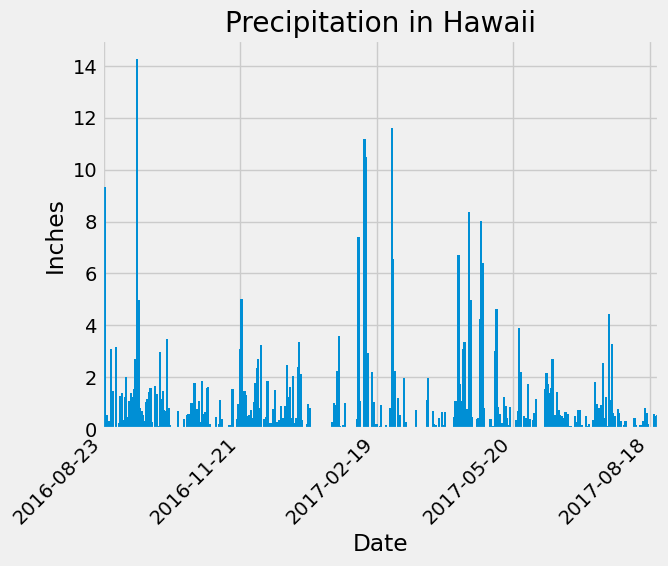

In [14]:
# Sort the dataframe by date
# convert to date
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
sorted_df=prcp_df.sort_values(by='date', ascending=False)
daily_data=sorted_df.groupby(sorted_df['date'])['precipitation'].sum()

# Use Pandas Plotting with Matplotlib to plot the data
ax = daily_data.plot(x="date", y="precipitation", kind="bar", width = 1.5)
plt.title('Precipitation in Hawaii')
plt.xlabel('Date')
plt.ylabel('Inches')

xtick_positions = range(0, len(daily_data), 90)
xtick_labels = daily_data.index[xtick_positions].strftime('%Y-%m-%d')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

plt.show()


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(StationClass).count()
station_count

9

In [44]:
all_stations = session.query(StationClass.station, StationClass.name).all()
all_stations

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query and count stations, ordering by count in descending order
station_counts = session.query(MeasurementClass.station, func.count(MeasurementClass.station)).\
group_by(MeasurementClass.station).order_by(func.count(MeasurementClass.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# How do I assign it to most_active_id = 
temps_active = session.query(
    func.min(MeasurementClass.tobs),
    func.max(MeasurementClass.tobs),
    func.avg(MeasurementClass.tobs)
).filter(MeasurementClass.station == 'USC00519281').all()

temps_active

[(54.0, 85.0, 71.66378066378067)]

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 

temp_results=session.query(MeasurementClass.date,MeasurementClass.tobs).\
    filter(MeasurementClass.date>=prev_year).\
    filter(MeasurementClass.station == 'USC00519281').\
    all()


In [34]:
# Convert the query results into a Pandas DataFrame
temps_df = pd.DataFrame(temp_results, columns=['date', 'temperature'])
temps_df

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


In [41]:
temp_results[0]._mapping

{'date': '2016-08-23', 'tobs': 77.0}

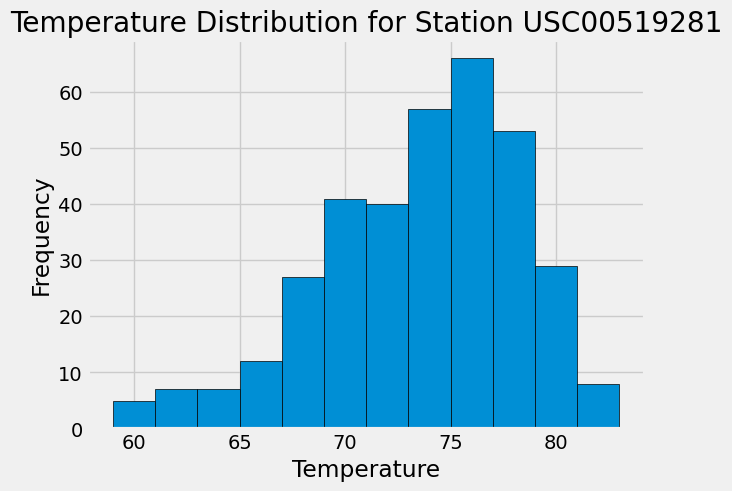

In [29]:
# and plot the results as a histogram
plt.hist(temps_df['temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution for Station USC00519281')
plt.show()

# Close Session

In [30]:
# Close Session
session.close()